GROUP MEMBERS :
- A91028407 - Manavbir Sahani, Data Analyzer & Communicator
- A15084019 - Ganesh Valliappan, Data Scraper & Analyzer
- A92089162 - Tsz Ho Hui, Data Scraper
- A14012032 - Shengzhi Wang, Data Visualizer
- A15370732 - Sheng Jie Yu, Data Analyzer
- A14385008 - Zebang Liu, Data Analyzer

---


# **0. Imports that Allow Our Programs to Work and Look Beautiful:**

In [1]:
%matplotlib inline
!pip install textblob bs4
!mkdir nltk_data
!python -m textblob.download_corpora
# !python -m nltk.downloader -d nltk_data stopword
!pwd

import warnings; warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
import re

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

from pylab import rcParams
rcParams['figure.figsize'] = 12, 8
plt.style.use('fivethirtyeight')

from collections import Counter
from datetime import datetime
from bs4 import BeautifulSoup
from random import *


import nltk
from nltk.corpus import webtext
from nltk.corpus import nps_chat
from nltk.corpus import movie_reviews
from nltk.corpus import stopwords

from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

nltk.download('stopwords')

    100% |████████████████████████████████| 634kB 1.5MB/s 
  Running setup.py bdist_wheel for bs4 ... - done
  Stored in directory: /content/.cache/pip/wheels/84/67/d4/9e09d9d5adede2ee1c7b7e8775ba3fbb04d07c4f946f0e4f11
Successfully built bs4
[nltk_data] Downloading package brown to /content/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /content/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /content/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /content/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /content/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /content/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.
/content
[nltk_data] 

True

# **1. Introduction and background :**

There were recent studies showing how facebook's personalization algorithms and engagement on media platforms end up filtering out people's viewpoints that are different from each user's own opnions. This practice led to the formation of echo-chambers and made people think their view is universally accepted. For example, the anti-Republican voters were led to think that Donald Trump would never win, and that had a susbstantial influence on voting. This was our first discovery of how media influences people's political beliefs.

We also discovered that television shows are a constant reflection of the current cultural, social, political state of the society at any given moment. This made us consider that there could be correlation. Since studies have shown what a tremendous impact media platforms like facebook can have on the political climate, then perhaps there is a possibility that television is not only a reflection of the political environment, but also can effect our opinions on politics. In other words, it can affect the way the real world's cultural, social, and political state of society.

We have learned about how television catches people's attention for several hours everyday, and how it has a tremendous impact on how people develop ideas about the world around them. We formed our research question on one of the most prominent use of television,(i.e TV shows) and their impact on shaping the American political climate. This drove us to the following question :<i> is there a correlation between the sentiments that television shows display about certain politicians and the way people's opinions change based on polling data? </i>


**Research question :** </p>
Do American television shows (e.g. South Park, Futurama, etc) have an impact on the political climate in america?
<br> <br>
**Hypothesis :** </p>
We hypothesize that there will be a positive correlation between the displayed political sentiments in television shows, and the political climate in America (i.e. positive political sentiments in the show towards a candidate improve public perception(measured by the change in poll results before and after the episode) of that candidate and vice versa.)


References (include links):
- 1) http://onlinelibrary.wiley.com/doi/10.1111/npqu.11519/epdf
- 2) https://www.encyclopedia.com/arts/news-wires-white-papers-and-books/televisions-impact-american-society-and-culture
- 3) https://people.howstuffworks.com/culture-traditions/tv-and-culture/advent-of-television-impact-politics.htm
- 4) https://www.huffingtonpost.com/entry/trump-political-dramas_us_592cff26e4b0df57cbfcf211
- 4) http://onlinelibrary.wiley.com/doi/10.1002/poi3.88/full


# **2. Data Description :**
<br> What data are we using?
1. We are using the scripts of episodes of SouthPark from season 1 to season 21 from  http://southpark.wikia.com . That's 287 episodes, and 76,000 lines of data.
2. We are using the airdates of Southpark episodes from IMDB.
3. We are using the weekly poll results from 1997 to present day, that has beem gathered by the University of Califonia, Santa Barbara through Gallup poles.

How are we getting this data?

Southpark episodes, airdates, and weekly poll results have been scrapped from the web.<br>

How did we combine the data we collected?

Using airdates and poll end dates, we found the poll taken immediately after an episode aired and matched the poll to that episode and the corresponding rows.


# **3. Data Cleaning / Pre-processing:**


## **South Park Data Cleaning and Processing**
Data scrapped from http://southpark.wikia.com/wiki/Portal:Scripts

### Processing South Park Wikia
The scripts for each episode is parsed by going through the main table given on the webpage for each episode. The main table contains two columns, the right column represents the character speaking the line and the left column is for the line spoken.

| Character       | Line                                                                  |
|:----------------|:----------------------------------------------------------------------|
| Kyle Broflovski | Ah, damn it! My little brother's trying to follow me to school again. |
| Ike Broflovski  | Zeeponaner.                                                           |
| Kyle            | Ike, you can't come to school with me. *[Ike Chortles.]*              |
|                 | *At the bus stop*                                                     |

The following is done for processing:
1. The asides (e.g. '[Ike Chortles]') are removed.
2. Characters with shortened names (e.g. Kyle and Kyle Broflovski) have their lines under the same name.
3. Rows where actions are written (e.g. 'At the bus stop') are removed (rows with no character cell).

In [0]:
# main page link
url = "http://southpark.wikia.com"
# location of all links to scripts
portal = "/wiki/Portal:Scripts"

def strip_season_url(link):
  return link[link.find('/Season'):]

def strip_extras(text):
  text = re.sub(r'\[[^\]]*\]', ' ', text).strip()
  return text

### Character Processing
Processes the cast list on the Wikia page per episode and returns a list containing all the characters that appear in the episode. The characters for each line is also processed because after their first occurance, the character names are shortend (e.g. Kyle Broflovski to Kyle and Mr. Herbert Garrison to Mr. Garrison).

In [0]:
# creates a list of the characters from the episode
def get_characters(ul_list):
  characters = list()
  for li in ul_list.findAll('li'):
    characters.append(li.get_text().strip())
  return characters

# matches a shorter character name to the full name from the episode cast
def match_character(name, char_list):
  subset = name.split(' ')
  for char in char_list:
    if set(subset).issubset(set(char.split(' '))):
      return char
  return name

### Episode Processing
Processes the main table on the page, which contains two columns: 'character' and 'line'. Each row contains one line said by a character. The lines containing actions on-screen (e.g. 'At the bus stop') are removed by checking for empty character cells, but non-empty line cells. Lines that multiple characters say at the same time are split apart into two, adjacent lines.

In [0]:
# parse the episode by getting all characters and matching lines for each character
def parse_episode(link, season, episode):
  # print('----------Episode:', link)
  episode_page = BeautifulSoup(requests.get(link).content, 'html.parser')
  script_table = episode_page.findAll('table')[1]
  chars = get_characters(episode_page.find(id='mw-content-text').find('ul'))

  # print('-------# of Lines:', len(script_table.find_all('tr')))
  script_table = script_table.find_all('tr')[1 : -1]

  temp = []

  for row in script_table:
    cell = row.contents
    if len(cell) >= 3:
      c = str(cell[1].text)
      l = str(cell[2].text)
      if not len(c) == 1 :
        name = re.sub('[^a-zA-Z1-9 ,]', ' ', c)
        name = re.sub('\\s+', ' ', name).strip()
        stripped_line = l.strip()
        for n in name.split(', '):
          n = match_character(n, chars)
          d = {}
          d['season'] = season
          d['episode'] = episode
          d['character'] = n
          d['line'] = stripped_line
          temp.append(d)
  return temp

### Season Processing
Processes the main table on the page that contains a link to each of the South Park episodes of a season--a loop goes through the link to each episode and returns a list containing the character and the text they said over all the seasons.

In [0]:
# loops through all episodes of a single season
def parse_season(link, season):
  # print('\n-----------Season:', link)

  season_page = BeautifulSoup(requests.get(link).content, 'html.parser')
  season_table = season_page.find('div', id='gallery-0')

  count = 1

  # print('----------# of Ep:', len(season_table.find_all('a', class_='link-internal')))
  temp = []
  for a in season_table.find_all('a', class_='link-internal'):
    k = parse_episode(url + a['href'], season, count)        
    count += 1
    temp.extend(k)
    if season == 21 and count == 10:
      break
  return temp

### South Park Wikia Scripts Portal
Process the main table on the scripts portal on the South Park Wikia (http://southpark.wikia.com/wiki/Portal:Scripts). It travereses through each season and each episode to create a DataFrame of episode scripts.

The DataFrame has the following columns:
* Season
* Episode
* Character
* Line

In [6]:
main_page = BeautifulSoup(requests.get(url + portal).content, 'html.parser')
main_table = main_page.find('div', id='gallery-0')

count = 1

a = main_table.findAll('a', class_='link-internal')[0]
temp = []

for a in main_table.findAll('a', class_='link-internal'):
  season_url = strip_season_url(a['href'])
  k = parse_season(url + portal + season_url, count)
  temp.extend(k)
  count += 1
    
scripts_master = pd.DataFrame(temp)
scripts_master.head()

,character,episode,line,season
0,Boys,1,"School day, school day, teacher's golden ru...",1
1,Kyle Broflovski,1,"Ah, damn it! My little brother's trying to fol...",1
2,Ike Broflovski,1,Zeeponaner.,1
3,Kyle Broflovski,1,"Ike, you can't come to school with me. [Ike Ch...",1
4,Eric Cartman,1,"Yeah, go home you little dildo!",1


For efficiency purposes, the website has already been scrapped by the previous code and stored in a CSV file.

In [7]:
scripts_url = 'https://raw.githubusercontent.com/GaneshV757/South-Park-Scripts/master/all-seasons-cleaned-sep.csv'
scripts_master = pd.read_csv(scripts_url, sep='}').drop('Unnamed: 0', 1)
scripts_master = scripts_master[pd.notnull(scripts_master['line'])]

def fix_garrison(char):
  if isinstance(char, str) and 'garrison' in char.lower():
    return 'Garrison'
  return char

scripts_master['character'] = scripts_master['character'].apply(fix_garrison)
scripts_master.head()

,season,episode,character,line
0,1,1,Boys,"School day, school day, teacher's golden ru..."
1,1,1,Kyle Broflovski,"Ah, damn it! My little brother's trying to fol..."
2,1,1,Ike Broflovski,Zeeponaner.
3,1,1,Kyle Broflovski,"Ike, you can't come to school with me."
4,1,1,Eric Cartman,"Yeah, go home you little dildo!"


## IMDB Data (for South Park) Processing
Episode names, airdates and ratings were scraped from IMDb using <a href="https://www.import.io">import.io</a> and the CSV file is imported as a DataFrame.

In [8]:
south_park_imdb_url = 'https://gist.githubusercontent.com/GaneshV757/fd8a7710b554a4cb01283543afe88940/raw/575c5591ea2825ef603a5f3bdd35e9fd09e6cad3/imdb_data.csv'
south_park_imdb = pd.read_csv(south_park_imdb_url)
south_park_imdb.head()

,season,episode,airdate,ep_name,imdb_rating
0,1,1,13-Aug-97,Cartman Gets an Anal Probe,8.2
1,1,2,20-Aug-97,Weight Gain 4000,7.9
2,1,3,27-Aug-97,Volcano,7.9
3,1,4,3-Sep-97,Big Gay Al's Big Gay Boat Ride,7.8
4,1,5,10-Sep-97,An Elephant Makes Love to a Pig,7.8


## Joining South Park Scripts and IMDB Data
The South Park scripts and the IMDB data are joined together into a DataFrame that now holds the columns:
* Season
* Episode
* Airdate (of episode)
* Ratings (of episode)
* Character
* Line

The airdates are also standardized (ISO 8601 format) for easier comparisons between dates.

In [9]:
scripts = scripts_master.copy()
for row in south_park_imdb.iterrows():
  row = row[1]
  scripts.loc[(scripts['season'] == row['season']) & (scripts['episode'] == row['episode']), 'airdate'] = row['airdate']
  scripts.loc[(scripts['season'] == row['season']) & (scripts['episode'] == row['episode']), 'ratings'] = row['imdb_rating']
  
def standard_date(date):
  formated = datetime.strptime(date, '%d-%b-%y')
  return formated

scripts['airdate'] = scripts['airdate'].apply(standard_date)
scripts = scripts[['season', 'episode', 'airdate', 'ratings', 'character', 'line']]
scripts.head()

,season,episode,airdate,ratings,character,line
0,1,1,1997-08-13,8.2,Boys,"School day, school day, teacher's golden ru..."
1,1,1,1997-08-13,8.2,Kyle Broflovski,"Ah, damn it! My little brother's trying to fol..."
2,1,1,1997-08-13,8.2,Ike Broflovski,Zeeponaner.
3,1,1,1997-08-13,8.2,Kyle Broflovski,"Ike, you can't come to school with me."
4,1,1,1997-08-13,8.2,Eric Cartman,"Yeah, go home you little dildo!"


## **Trump Job Approval Data Processing and Cleaning**
Data scraped from University of California Santa Barbara (UCSB) (http://www.presidency.ucsb.edu/data/popularity.php?pres=45&sort=time&direct=DESC&Submit=DISPLAY). The main table in the page contains the date of each poll as well as the percent approval, disapproval, and uncertain for that poll.

In [10]:
trump_url = 'http://www.presidency.ucsb.edu/data/popularity.php?pres=45&sort=time&direct=DESC&Submit=DISPLAY'
trump_page = requests.get(trump_url)
trump_soup = BeautifulSoup(trump_page.content, 'html.parser')
rows = trump_soup.find_all('table')[10].find_all('tr')[4:]
trump = pd.DataFrame()
r = 0
c = 0
for tr in rows:
  cols = tr.find_all('td')
  for td in cols:
    trump.loc[r,c] = td.text
    c = c + 1
  r = r + 1  
  c = 0 
  
trump = trump.drop(3, axis=1)
trump.columns = trump.loc[0]
trump = trump.drop([0, 1])
trump = trump.reset_index(drop=True)

trump['int_approval'] = pd.to_numeric(trump['Approving '])
trump['normalized_approval'] = trump['int_approval']
#trump['normalized_approval'] = (trump['int_approval'] - np.mean(trump['int_approval'])) / np.std(trump['int_approval'])

trump['standard_datetime'] = [datetime.strptime(x, '%m/%d/%Y') for x in trump['End Date ']]

trump.head()

,President,Start Date,End Date,Approving,Disapproving,unsure/no data,int_approval,normalized_approval,standard_datetime
0,Donald J. Trump,02/26/2018,03/04/2018,39,55,6,39,39,2018-03-04
1,,02/19/2018,02/25/2018,39,56,5,39,39,2018-02-25
2,,02/12/2018,02/18/2018,37,59,4,37,37,2018-02-18
3,,02/05/2018,02/11/2018,40,57,3,40,40,2018-02-11
4,,01/29/2018,02/04/2018,40,57,3,40,40,2018-02-04


## **Obama Job Approval Data Processing and Cleaning**
Data scraped from UCSB (http://www.presidency.ucsb.edu/data/popularity.php?pres=44&sort=time&direct=DESC&Submit=DISPLAY). The main table in the page contains the date of each poll as well as the percent approval, disapproval, and uncertain for that poll.

In [11]:
obama_url = 'http://www.presidency.ucsb.edu/data/popularity.php?pres=44&sort=time&direct=DESC&Submit=DISPLAY'
obama_page = requests.get(obama_url)
obama_soup = BeautifulSoup(obama_page.content, 'html.parser')
rows = obama_soup.find_all('table')[10].find_all('tr')[4:]
obama = pd.DataFrame()
r = 0
c = 0
for tr in rows:
  cols = tr.find_all('td')
  for td in cols:
    obama.loc[r,c] = td.text
    c = c + 1
  r = r + 1  
  c = 0 
  
obama = obama.drop(3, axis=1)
obama.columns = obama.loc[0]
obama = obama.drop([0, 1])
obama = obama.reset_index(drop=True)

obama['int_approval'] = pd.to_numeric(obama['Approving '])
obama['normalized_approval'] = obama['int_approval']
#obama['normalized_approval'] = (obama['int_approval'] - np.mean(obama['int_approval'])) / np.std(obama['int_approval'])

obama['standard_datetime'] = [datetime.strptime(x, '%m/%d/%Y') for x in obama['End Date ']]

obama.head()

,President,Start Date,End Date,Approving,Disapproving,unsure/no data,int_approval,normalized_approval,standard_datetime
0,Barack Obama,01/17/2017,01/19/2017,59,37,4,59,59,2017-01-19
1,,01/15/2017,01/18/2017,58,38,4,58,58,2017-01-18
2,,01/14/2017,01/17/2017,57,39,4,57,57,2017-01-17
3,,01/13/2017,01/15/2017,57,38,5,57,57,2017-01-15
4,,01/12/2017,01/14/2017,57,39,4,57,57,2017-01-14


## **Bush Job Approval Data Processing and Cleaning**
Data scraped from UCSB (http://www.presidency.ucsb.edu/data/popularity.php?pres=43&sort=time&direct=DESC&Submit=DISPLAY). The main table in the page contains the date of each poll as well as the percent approval, disapproval, and uncertain for that poll.

In [12]:
bush_url = 'http://www.presidency.ucsb.edu/data/popularity.php?pres=43&sort=time&direct=DESC&Submit=DISPLAY'
bush_page = requests.get(bush_url)
bush_soup = BeautifulSoup(bush_page.content, 'html.parser')
rows = bush_soup.find_all('table')[10].find_all('tr')[4:]
bush = pd.DataFrame()
r = 0
c = 0
for tr in rows:
  cols = tr.find_all('td')
  for td in cols:
    bush.loc[r,c] = td.text
    c = c + 1
  r = r + 1  
  c = 0 
  
bush = bush.drop(3, axis=1)
bush.columns = bush.loc[0]
bush = bush.drop([0, 1])
bush = bush.reset_index(drop=True)

bush['int_approval'] = pd.to_numeric(bush['Approving '])
bush['normalized_approval'] = bush['int_approval']
#bush['normalized_approval'] = (bush['int_approval'] - np.mean(bush['int_approval'])) / np.std(bush['int_approval'])

bush['standard_datetime'] = [datetime.strptime(x, '%m/%d/%Y') for x in bush['End Date ']]

bush.head()

,President,Start Date,End Date,Approving,Disapproving,unsure/no data,int_approval,normalized_approval,standard_datetime
0,George W. Bush,01/09/2009,01/11/2009,34,61,5,34,34,2009-01-11
1,,12/12/2008,12/14/2008,29,67,4,29,29,2008-12-14
2,,12/04/2008,12/07/2008,32,61,7,32,32,2008-12-07
3,,11/13/2008,11/16/2008,29,66,4,29,29,2008-11-16
4,,11/07/2008,11/09/2008,28,68,5,28,28,2008-11-09


## **Clinton Job Approval Data Processing and Cleaning**
Data scraped from UCSB (http://www.presidency.ucsb.edu/data/popularity.php?pres=42&sort=time&direct=DESC&Submit=DISPLAY). The main table in the page contains the date of each poll as well as the percent approval, disapproval, and uncertain for that poll.

In [13]:
clinton_url = 'http://www.presidency.ucsb.edu/data/popularity.php?pres=42&sort=time&direct=DESC&Submit=DISPLAY'
clinton_page = requests.get(clinton_url)
clinton_soup = BeautifulSoup(clinton_page.content, 'html.parser')
rows = clinton_soup.find_all('table')[10].find_all('tr')[4:]
clinton = pd.DataFrame()
r = 0
c = 0
for tr in rows:
  cols = tr.find_all('td')
  for td in cols:
    clinton.loc[r,c] = td.text
    c = c + 1
  r = r + 1  
  c = 0 
  
clinton = clinton.drop(3, axis=1)
clinton.columns = clinton.loc[0]
clinton = clinton.drop([0, 1])
clinton = clinton.reset_index(drop=True)

clinton['int_approval'] = pd.to_numeric(clinton['Approving '])
clinton['normalized_approval'] = clinton['int_approval']
#clinton['normalized_approval'] = (clinton['int_approval'] - np.mean(clinton['int_approval']))/ np.std(clinton['int_approval'])

clinton['standard_datetime'] = [datetime.strptime(x, '%m/%d/%Y') for x in clinton['End Date ']]

clinton.head()

,President,Start Date,End Date,Approving,Disapproving,unsure/no data,int_approval,normalized_approval,standard_datetime
0,William J. Clinton,01/10/2001,01/14/2001,66,29,5,66,66,2001-01-14
1,,01/05/2001,01/07/2001,63,31,4,63,63,2001-01-07
2,,12/15/2000,12/17/2000,71,26,1,71,71,2000-12-17
3,,12/02/2000,12/04/2000,59,35,5,59,59,2000-12-04
4,,11/13/2000,11/15/2000,63,32,4,63,63,2000-11-15


## **Concatenating All Poll Data**
Concatenate poll data from all four presidents in in the order from oldest to newest

In [0]:
overall_poll = pd.concat([trump,obama,bush,clinton])
overall_poll = overall_poll.reset_index(drop=True)
overall_poll_reverse = overall_poll[::-1]
s = pd.Series(overall_poll_reverse['standard_datetime'])
overall_poll_reverse['standard_datetime_num'] = pd.to_numeric(s)
overall_poll_reverse['Disapproving_int'] = pd.to_numeric(overall_poll_reverse['Disapproving '])

## Applying Sentiment Data From Scripts

### Helper functions:
1. line_sentiment takes in a line and returns the polarity and subjectivity of the given line.
2. episode_char_avg_sentiment takes in a list of lines and returns the average polarity and average subjectivity of all the given lines.

In [0]:
def line_sentiment(line):
  blob = TextBlob(line)
  avg_polarity = np.average(list(map(lambda x: x.sentiment.polarity, blob.sentences)))
  avg_subjectivity = np.average(list(map(lambda x: x.sentiment.subjectivity, blob.sentences)))
  return (avg_polarity, avg_subjectivity)

def episode_char_avg_sentiment(lines):
  sentiments = list(map(line_sentiment, lines))
  avg_polarity = np.average(list(map(lambda x: x[0], sentiments)))
  avg_subjectivity = np.average(list(map(lambda x: x[1], sentiments)))
  return (avg_polarity, avg_subjectivity)

### Calculating the Sentiment Data
The average sentiment and subjectivity of each character per episode per season is calculated and stored in a DataFrame. This is done by looping through each season, each episode, and each unique character and using the helper functions to calculate the average sentiment and subjectivity of the character's lines.

In [16]:
df_stmt = pd.DataFrame(columns = ['season', 'episode', 'ratings', 'airdate', 'character', 'avg_polarity', 'avg_subjectivity'])

for season in scripts['season'].unique():
  for episode in scripts[scripts['season'] == season]['episode'].unique():
    episode_entries = scripts.loc[(scripts['season'] == season) & (scripts['episode'] == episode)]
    ratings = episode_entries['ratings'].values[0]
    airdate = episode_entries['airdate'].values[0]
    for character in episode_entries['character'].unique():
      lines = episode_entries.loc[episode_entries['character'] == character]['line']
      (avg_pol, avg_sub) = episode_char_avg_sentiment(lines)
      df_stmt = df_stmt.append({'season': season, 'episode': episode, 'ratings': ratings, 'airdate': airdate, 'character': character, 'avg_polarity': avg_pol, 'avg_subjectivity': avg_sub}, ignore_index=True)
      
df_stmt.head()

,season,episode,ratings,airdate,character,avg_polarity,avg_subjectivity
0,1,1,8.2,1997-08-13,Boys,0.012500,0.250000
1,1,1,8.2,1997-08-13,Kyle Broflovski,-0.011376,0.172284
2,1,1,8.2,1997-08-13,Ike Broflovski,0.072727,0.081818
3,1,1,8.2,1997-08-13,Eric Cartman,-0.007283,0.170141
4,1,1,8.2,1997-08-13,Stan Marsh,0.023655,0.174807


## **Matching Poll Data and Combining Data**
Match normalized poll data to the original imdb airdate data first because the imdb data preserve a single episode airdate per row. The algorithm finds the poll number that has an end date that corresponds to the airdate of an episode and matches the poll number to that episode

In [17]:
by_episodes = pd.read_csv(south_park_imdb_url)
by_episodes['airdate'] = by_episodes['airdate'].apply(standard_date)
by_episodes['poll_num'] = ''

for x in range(0, by_episodes.shape[0]):
  if x == by_episodes.shape[0] - 1:
    by_episodes['poll_num'][x] = (overall_poll['normalized_approval'].loc[(overall_poll['standard_datetime'] > by_episodes['airdate'][x])]).iloc[-1]
  else:
    poll_nums = (overall_poll['normalized_approval'].loc[(overall_poll['standard_datetime'] > by_episodes['airdate'][x]) & (overall_poll['standard_datetime'] < by_episodes['airdate'][x+1])])
    if poll_nums.size > 0:
      by_episodes['poll_num'][x] = poll_nums.iloc[-1]
by_episodes.head()

,season,episode,airdate,ep_name,imdb_rating,poll_num
0,1,1,1997-08-13,Cartman Gets an Anal Probe,8.2,
1,1,2,1997-08-20,Weight Gain 4000,7.9,60
2,1,3,1997-08-27,Volcano,7.9,
3,1,4,1997-09-03,Big Gay Al's Big Gay Boat Ride,7.8,60
4,1,5,1997-09-10,An Elephant Makes Love to a Pig,7.8,


Match poll number from imdb data to sentiment analysis data using the poll dates and airdates.

In [0]:
df_stmt['poll_num'] = ""
for i in range(0, by_episodes.shape[0]):
  df_stmt['poll_num'][df_stmt['airdate'] == by_episodes['airdate'][i]] = by_episodes['poll_num'][i]

Take out rows with no poll numbers.

In [19]:
df_stmt = df_stmt[df_stmt['poll_num'] != ""]
df_stmt.head()

,season,episode,ratings,airdate,character,avg_polarity,avg_subjectivity,poll_num
24,1,2,7.9,1997-08-20,Kyle Broflovski,0.064593,0.250926,60
25,1,2,7.9,1997-08-20,Stan Marsh,0.038760,0.335099,60
26,1,2,7.9,1997-08-20,Eric Cartman,-0.008236,0.215424,60
27,1,2,7.9,1997-08-20,Garrison,0.122958,0.283802,60
28,1,2,7.9,1997-08-20,Wendy Testaburger,0.075320,0.108849,60


# **4. Data Analysis and Visualization :**


## **Scatter Plot Graph of Presidental Approval Rates**

This graph shows the presidential approval rate over time. Each significant sudden change indicate that a new president has been elected (~0: Clinton; ~10: Bush; ~12.3: Obama; ~14.8: Trump).



Text(0,0.5,'Percent Approval')

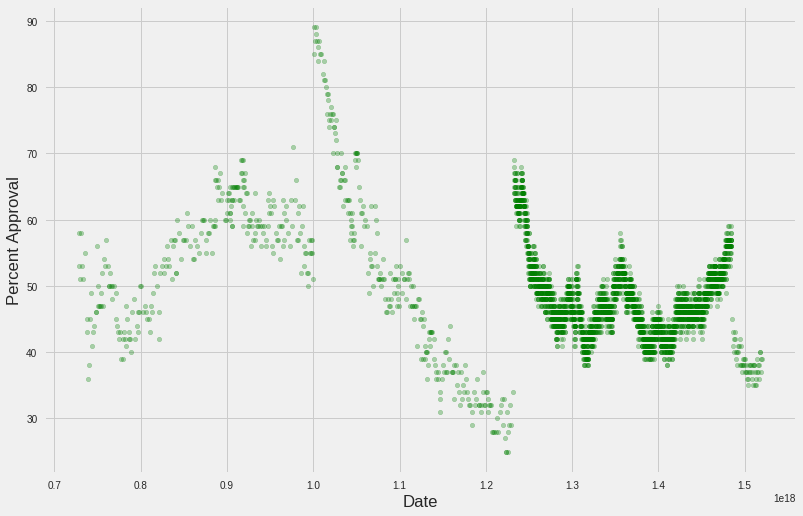

In [20]:
ax = overall_poll_reverse.plot.scatter(x="standard_datetime_num",y="int_approval", c='green', alpha=0.3)
ax.set_xlabel('Date')
ax.set_ylabel('Percent Approval')

## Getting Sentiment Data Over Time for a Character
Finds a slice of the sentiment DataFrame given a character name.

In [0]:
def get_character_sentiment(character_name):
  df2 = df_stmt.loc[(df_stmt['character'] == character_name)]
  df2.groupby(['season', 'episode'])[['avg_polarity']].mean().reset_index()
  df3 = df2.groupby(['season', 'episode'])[['avg_polarity']].mean().reset_index()
  im = pd.read_csv(south_park_imdb_url)
  return im.merge(df3, on=['season', 'episode'], how='left')['avg_polarity'].fillna(0)

### Sample Character Sentiment Plots over Time
The graphs below illustrate the change in sentiments for a character over 250 episodes of South Park.
1. Kyle Broflovski: One of the main characters of the show. He is often noted for being a member of the only Jewish family in South Park and known for his intelligence.
2. Ike Broflovski: Kyle's younger brother who does not talk at all save for a few episodes (he is a check for neutral sentiment).
3. Eric Cartman: Another one of the main characters of the show. He is sometimes the main antagonist of an episode and the other main characters often wonder why they hang out with him. He has strained relationships with his friends many times.
4. Mr. Herbert Garrison: A former fourth-grade teacher at South Park Elementary before running for and being elected as the 45th President of South Park. Creators of South Park use him to represent President Trump.

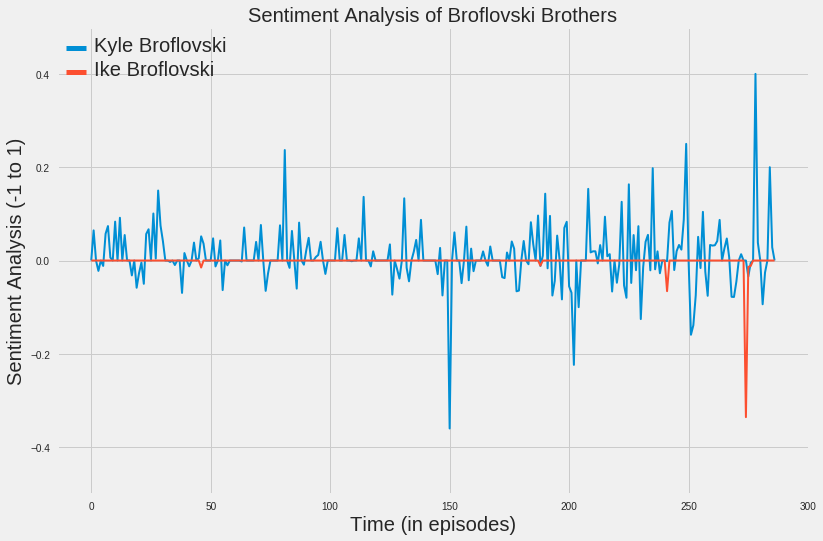

In [22]:
plot1 = plt.figure()
ax1 = plot1.add_subplot(111)
ax1.set_xlabel('Time (in episodes)', fontsize='x-large')
ax1.set_ylabel('Sentiment Analysis (-1 to 1)', fontsize='x-large')
plot1 = get_character_sentiment('Kyle Broflovski').plot(title='Sentiment Analysis of Broflovski Brothers', ylim=(-0.5,0.5), label='Kyle Broflovski', ax=ax1, linewidth=2)
get_character_sentiment('Ike Broflovski').plot(ax=ax1, label='Ike Broflovski', linewidth=2)

legend1 = plt.legend()

for line in legend1.get_lines():
  line.set_linewidth(5)

for text in legend1.get_texts():
  text.set_fontsize('x-large')

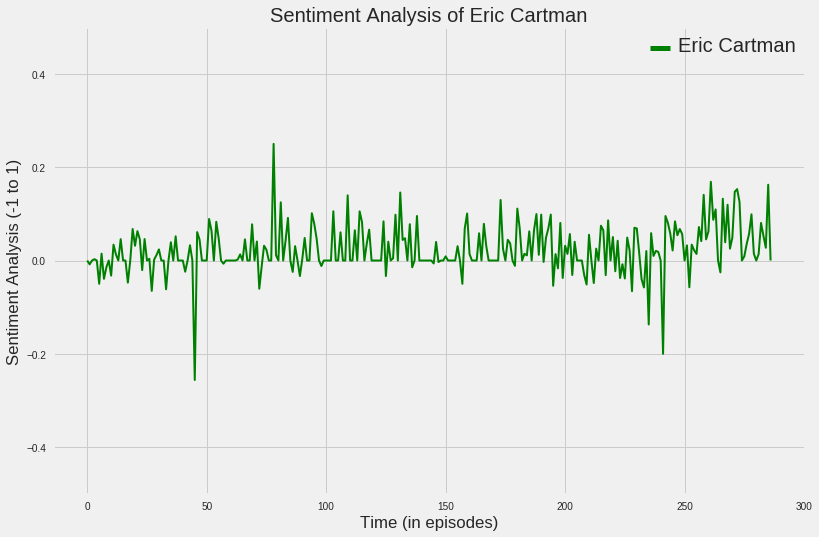

In [23]:
plot2 = plt.figure()
ax2 = plot2.add_subplot(111)
ax2.set_xlabel('Time (in episodes)')
ax2.set_ylabel('Sentiment Analysis (-1 to 1)')
plot2 = get_character_sentiment('Eric Cartman').plot(title='Sentiment Analysis of Eric Cartman', ylim=(-0.5,0.5), label='Eric Cartman', ax=ax2, linewidth=2, c='g')

legend2 = plt.legend()

for line in legend2.get_lines():
  line.set_linewidth(5)

for text in legend2.get_texts():
  text.set_fontsize('x-large')

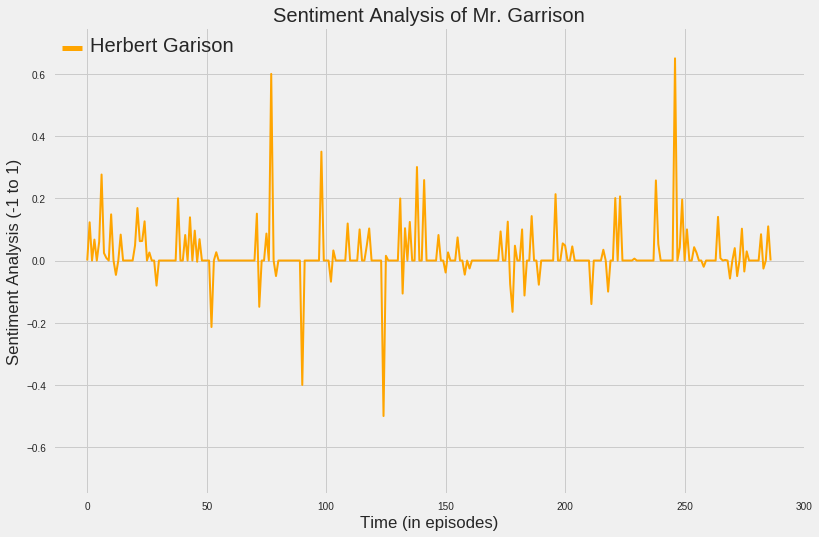

In [24]:
plot3 = plt.figure()
ax3 = plot3.add_subplot(111)
ax3.set_xlabel('Time (in episodes)')
ax3.set_ylabel('Sentiment Analysis (-1 to 1)')
plot3 = get_character_sentiment('Garrison').plot(title='Sentiment Analysis of Mr. Garrison', ylim=(-0.75,0.75), label='Herbert Garison', ax=ax3, linewidth=2, c='orange')

legend3 = plt.legend()

for line in legend3.get_lines():
  line.set_linewidth(5)

for text in legend3.get_texts():
  text.set_fontsize('x-large')

# **Word Frequency**

### Helper Classes
The following classes are used to store the list of words vs. frequencies and the list of nouns vs. frequencies. This is helpful for storing the objects in a DataFrame.

In [0]:
class WordCounter(object):
  __counter = None
  
  def __init__(self, c):
    self.__counter = c
    
  def get_counter(self):
    return self.__counter

class NounCounter(object):
  __dict = None
  
  def __init__(self, l):
    self.__dict = l
    
  def get_dict(self):
    return self.__dict

### Calculating Word Frequency
All the lines in an episode's script are joined together, then the Counter class in the Python Collections package is used to calculate the frequencies of each unique word in the script. Stopwords, such as "I", "YOU", and "THIS", are filtered out. The list of stopwords comes from the NLTK package.

In [0]:
def stringify(line_list):
  text = ' '.join(line_list)
  return text

def word_counter(text):
  word_list = re.findall(r'\w+', text)
  filtered_words = [word.upper().strip() for word in word_list if word.lower() not in stopwords.words('english')]
  return WordCounter(Counter(filtered_words))

### Calculating Noun Phrase Frequency
All the lines in an episode's script are joined together, then the noun counts method in the TextBlob package is used to identify and calculate the number of times unique noun phrases.
There are specific noun phrases, such "GUN CONTROL", "REPUBLICAN", and "POT OF GOLD", that may be interesting to analyze.

In [0]:
# Does a word count for each noun in the specified episode
def count_nouns(season, episode):
  text = stringify(scripts.loc[(scripts['season'] == season) & (scripts['episode'] == episode)]['line'].values.tolist())
  blob = TextBlob(text)
  noun_counts = {noun.upper(): blob.noun_phrases.count(noun) for noun in set(blob.noun_phrases)}
  return NounCounter(noun_counts)

### Applying Word/Noun Frequency Analysis to South Park
The above unique word frequency and noun phrase frequency calculating methods are used to store the counts for each episode.

In [28]:
word_freq = south_park_imdb.copy()
word_freq['word_counter'] = np.nan
word_freq['noun_counter'] = np.nan

for row in south_park_imdb.iterrows():
  row = row[1]
  season = row['season']
  episode = row['episode']
  text = stringify(scripts[(scripts['season'] == season) & (scripts['episode'] == episode)]['line'].values.tolist())
  word_counts = word_counter(text)
  word_freq.loc[(word_freq['season'] == season) & (word_freq['episode'] == episode), 'word_counter'] = word_counts
  word_freq.loc[(word_freq['season'] == season) & (word_freq['episode'] == episode), 'noun_counter'] = count_nouns(season, episode)

copy_df = word_freq.copy()
word_freq.head()

,season,episode,airdate,ep_name,imdb_rating,word_counter,noun_counter
0,1,1,13-Aug-97,Cartman Gets an Anal Probe,8.2,<__main__.WordCounter object at 0x7f8ce212f240>,<__main__.NounCounter object at 0x7f8ce21f4e48>
1,1,2,20-Aug-97,Weight Gain 4000,7.9,<__main__.WordCounter object at 0x7f8cdd4fb9e8>,<__main__.NounCounter object at 0x7f8cdd4cb278>
2,1,3,27-Aug-97,Volcano,7.9,<__main__.WordCounter object at 0x7f8cdd4c6908>,<__main__.NounCounter object at 0x7f8cdd4a27b8>
3,1,4,3-Sep-97,Big Gay Al's Big Gay Boat Ride,7.8,<__main__.WordCounter object at 0x7f8cdd51c8d0>,<__main__.NounCounter object at 0x7f8cdd56d7b8>
4,1,5,10-Sep-97,An Elephant Makes Love to a Pig,7.8,<__main__.WordCounter object at 0x7f8cdd4ae198>,<__main__.NounCounter object at 0x7f8cdd56f978>


In [29]:
word_freq = copy_df.copy()

word_freq['airdate'] = word_freq['airdate'].apply(standard_date)
word_freq['poll_num'] = ""
for i in range(0, by_episodes.shape[0]):
  word_freq.loc[word_freq['airdate'] == by_episodes['airdate'][i], 'poll_num'] = by_episodes['poll_num'][i]
word_freq = word_freq[word_freq['poll_num'] != ""]

word_freq['poll_num'] = word_freq['poll_num'].apply(pd.to_numeric)

word_freq.head()

,season,episode,airdate,ep_name,imdb_rating,word_counter,noun_counter,poll_num
1,1,2,1997-08-20,Weight Gain 4000,7.9,<__main__.WordCounter object at 0x7f8cdd4fb9e8>,<__main__.NounCounter object at 0x7f8cdd4cb278>,60
3,1,4,1997-09-03,Big Gay Al's Big Gay Boat Ride,7.8,<__main__.WordCounter object at 0x7f8cdd51c8d0>,<__main__.NounCounter object at 0x7f8cdd56d7b8>,60
5,1,6,1997-09-17,Death,8.2,<__main__.WordCounter object at 0x7f8cdd45a748>,<__main__.NounCounter object at 0x7f8cdd47acc0>,57
6,1,7,1997-10-29,Pinkeye,8.5,<__main__.WordCounter object at 0x7f8cdd4831d0>,<__main__.NounCounter object at 0x7f8cdd41c470>,58
7,1,8,1997-11-19,Starvin' Marvin,8.2,<__main__.WordCounter object at 0x7f8cdd7303c8>,<__main__.NounCounter object at 0x7f8cdd4c09b0>,60


In [30]:
def append_word_freq(df, word):
  for row in df.iterrows():
    row = row[1]
    df.loc[(df['season'] == row['season']) & (df['episode'] == row['episode']), word.upper()] = row['word_counter'].get_counter().get(word.upper())
  df[word.upper()] = df[word.upper()].fillna(0)

def append_list_freq(l):
  for word in l:
    append_word_freq(word_freq, word.upper())

append_list_freq(['election', 'vote', 'fuck', 'shit', 'trust', 'hello', 'mexico', 'canada', 'jobs'])

#word_freq.plot.scatter(x=word, y='poll_num')
word_freq.head()

,season,episode,airdate,ep_name,imdb_rating,word_counter,noun_counter,poll_num,ELECTION,VOTE,FUCK,SHIT,TRUST,HELLO,MEXICO,CANADA,JOBS
1,1,2,1997-08-20,Weight Gain 4000,7.9,<__main__.WordCounter object at 0x7f8cdd4fb9e8>,<__main__.NounCounter object at 0x7f8cdd4cb278>,60,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
3,1,4,1997-09-03,Big Gay Al's Big Gay Boat Ride,7.8,<__main__.WordCounter object at 0x7f8cdd51c8d0>,<__main__.NounCounter object at 0x7f8cdd56d7b8>,60,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
5,1,6,1997-09-17,Death,8.2,<__main__.WordCounter object at 0x7f8cdd45a748>,<__main__.NounCounter object at 0x7f8cdd47acc0>,57,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
6,1,7,1997-10-29,Pinkeye,8.5,<__main__.WordCounter object at 0x7f8cdd4831d0>,<__main__.NounCounter object at 0x7f8cdd41c470>,58,0.0,0.0,0.0,2.0,0.0,5.0,0.0,0.0,0.0
7,1,8,1997-11-19,Starvin' Marvin,8.2,<__main__.WordCounter object at 0x7f8cdd7303c8>,<__main__.NounCounter object at 0x7f8cdd4c09b0>,60,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0


We decided to study South Park due to it being a political satire cartoon, which could influence how its audience perceive certain political issues and presidential candidates. Additionally, since the show is written and produced in only a week, it can better reflect real world events. The graphs below illustrate that the show makes more political references during election years. In particular, the words 'Election' and 'Vote' were mentioned significantly more frequently during the seasons that correspond to election years.

Text(0.5,1,'Number of times "Election" is mentioned')

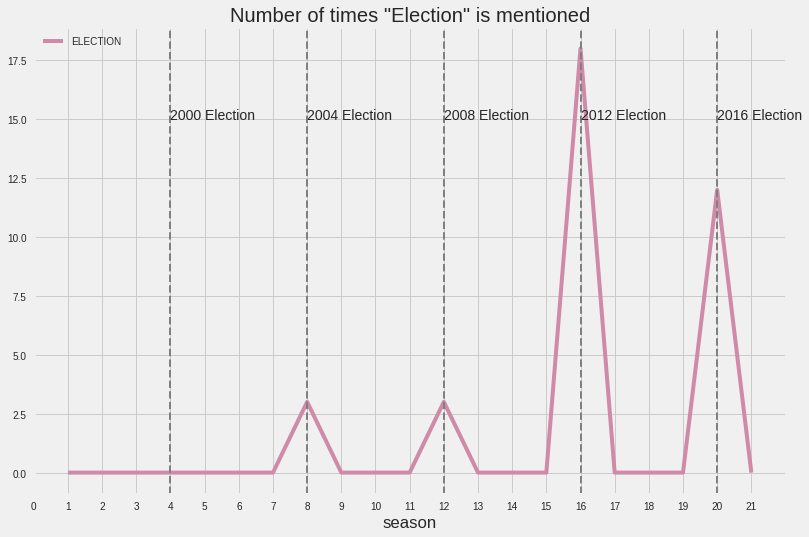

In [31]:
# number of times the word 'election' is mentioned

r = int(randint(10, 90))
g = int(randint(10, 90))
b = int(randint(10, 90))
color = [r*.01, g*.01, b*.01]

pres = word_freq.groupby(['season'])[['ELECTION']].sum()
pres.plot(xticks = range(0,22), c=color)
plt.axvline(x=4, ls = '--', lw = 2, c = 'grey')
plt.axvline(x=8, ls = '--', lw = 2, c = 'grey')
plt.axvline(x=12, ls = '--', lw = 2, c = 'grey')
plt.axvline(x=16, ls = '--', lw = 2, c = 'grey')
plt.axvline(x=20, ls = '--', lw = 2, c = 'grey')
plt.annotate('2000 Election',xy=(4,15))
plt.annotate('2004 Election',xy=(8,15))
plt.annotate('2008 Election',xy=(12,15))
plt.annotate('2012 Election',xy=(16,15))
plt.annotate('2016 Election',xy=(20,15))
plt.title('Number of times "Election" is mentioned')

Text(0.5,1,'Number of times "Vote" is mentioned')

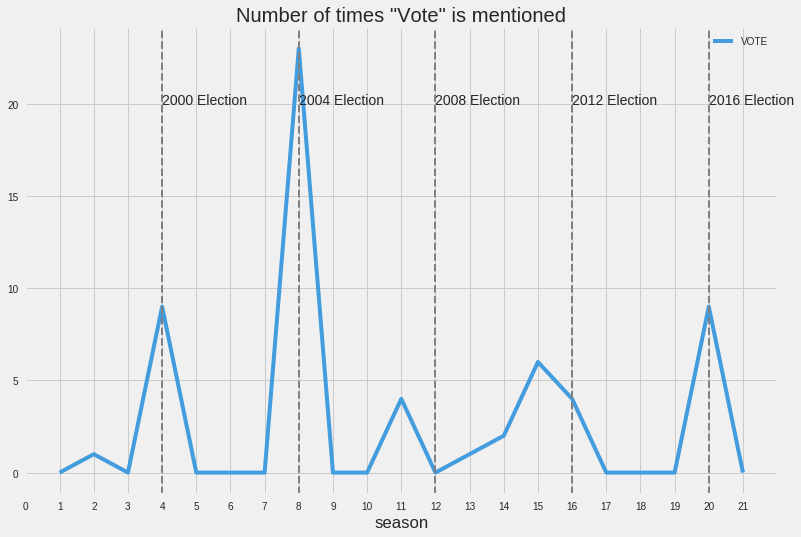

In [32]:
r = int(randint(10, 90))
g = int(randint(10, 90))
b = int(randint(10, 90))
color = [r*.01, g*.01, b*.01]

pres = word_freq.groupby(['season'])[['VOTE']].sum()
pres.plot(xticks = range(0,22), c = color)
plt.axvline(x=4, ls = '--', lw = 2, c = 'grey')
plt.axvline(x=8, ls = '--', lw = 2, c = 'grey')
plt.axvline(x=12, ls = '--', lw = 2, c = 'grey')
plt.axvline(x=16, ls = '--', lw = 2, c = 'grey')
plt.axvline(x=20, ls = '--', lw = 2, c = 'grey')
plt.annotate('2000 Election',xy=(4,20))
plt.annotate('2004 Election',xy=(8,20))
plt.annotate('2008 Election',xy=(12,20))
plt.annotate('2012 Election',xy=(16,20))
plt.annotate('2016 Election',xy=(20,20))
plt.title('Number of times "Vote" is mentioned')

South Park is also known for having quite a number of vulgar phrases. Interestingly, the word 'sh*t' seems to drop during election years--there seems to a correlation between the frequency of the word and the election year.

Text(0.5,1,'Number of times "Sh*t" is mentioned')

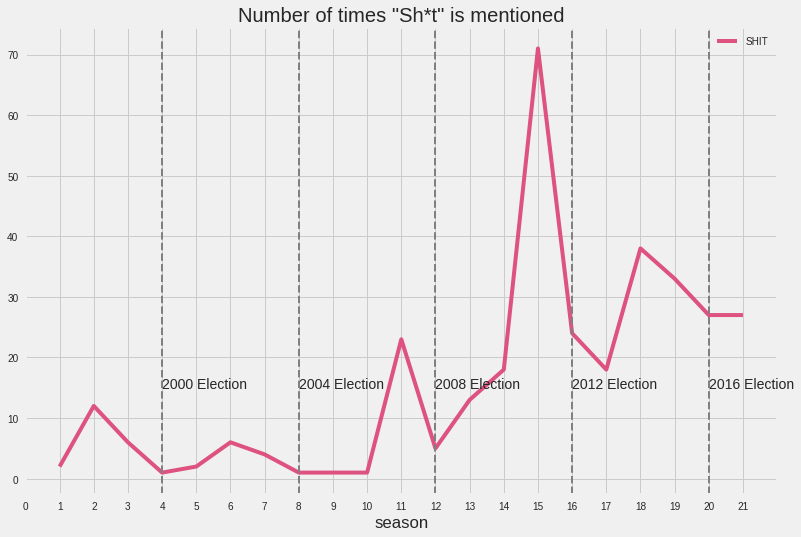

In [33]:
r = int(randint(10, 90))
g = int(randint(10, 90))
b = int(randint(10, 90))
color = [r*.01, g*.01, b*.01]


pres = word_freq.groupby(['season'])[['SHIT']].sum()
pres.plot(xticks = range(0,22), c= color)
plt.axvline(x=4, ls = '--', lw = 2, c = 'grey')
plt.axvline(x=8, ls = '--', lw = 2, c = 'grey')
plt.axvline(x=12, ls = '--', lw = 2, c = 'grey')
plt.axvline(x=16, ls = '--', lw = 2, c = 'grey')
plt.axvline(x=20, ls = '--', lw = 2, c = 'grey')
plt.annotate('2000 Election',xy=(4,15))
plt.annotate('2004 Election',xy=(8,15))
plt.annotate('2008 Election',xy=(12,15))
plt.annotate('2012 Election',xy=(16,15))
plt.annotate('2016 Election',xy=(20,15))
plt.title('Number of times "Sh*t" is mentioned')

America's two bordering countries, Mexico and Canada, are hot sources of debate during election years--especially during the 2016 elections. There seems to be no correlation between each word and the election year. The words increase in frequency in some elections years and dip in others.

Text(0.5,1,'Number of times "Mexico" is mentioned')

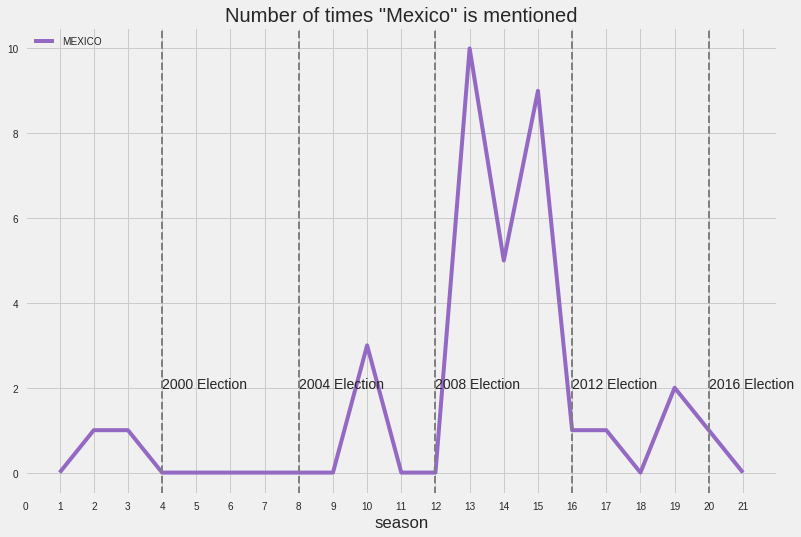

In [34]:
r = int(randint(10, 90))
g = int(randint(10, 90))
b = int(randint(10, 90))
color = [r*.01, g*.01, b*.01]


pres = word_freq.groupby(['season'])[['MEXICO']].sum()
pres.plot(xticks = range(0,22),  c= color)
plt.axvline(x=4, ls = '--', lw = 2, c = 'grey')
plt.axvline(x=8, ls = '--', lw = 2, c = 'grey')
plt.axvline(x=12, ls = '--', lw = 2, c = 'grey')
plt.axvline(x=16, ls = '--', lw = 2, c = 'grey')
plt.axvline(x=20, ls = '--', lw = 2, c = 'grey')
plt.annotate('2000 Election',xy=(4,2))
plt.annotate('2004 Election',xy=(8,2))
plt.annotate('2008 Election',xy=(12,2))
plt.annotate('2012 Election',xy=(16,2))
plt.annotate('2016 Election',xy=(20,2))
plt.title('Number of times "Mexico" is mentioned')

Text(0.5,1,'Number of times "Canada" is mentioned')

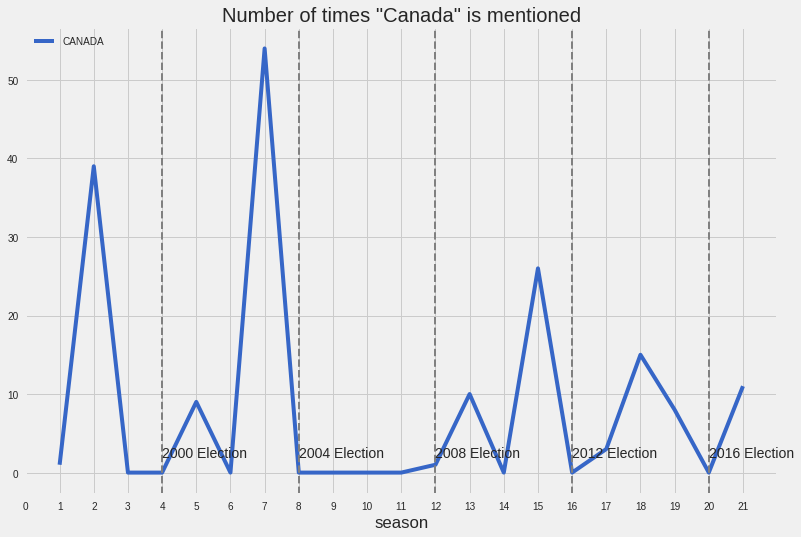

In [35]:
r = int(randint(10, 90))
g = int(randint(10, 90))
b = int(randint(10, 90))
color = [r*.01, g*.01, b*.01]

pres = word_freq.groupby(['season'])[['CANADA']].sum()
pres.plot(xticks = range(0,22),c= color)
plt.axvline(x=4, ls = '--', lw = 2, c = 'grey')
plt.axvline(x=8, ls = '--', lw = 2, c = 'grey')
plt.axvline(x=12, ls = '--', lw = 2, c = 'grey')
plt.axvline(x=16, ls = '--', lw = 2, c = 'grey')
plt.axvline(x=20, ls = '--', lw = 2, c = 'grey')
plt.annotate('2000 Election',xy=(4,2))
plt.annotate('2004 Election',xy=(8,2))
plt.annotate('2008 Election',xy=(12,2))
plt.annotate('2012 Election',xy=(16,2))
plt.annotate('2016 Election',xy=(20,2))
plt.title('Number of times "Canada" is mentioned')

Jobs, and the job market, are also a great source of debate during Presidential elections. However South Park does not seem to reflect this, as shown by a lack of constant peaks or drops in "job" frequency during election years.

Text(0.5,1,'Number of times "Jobs" is mentioned')

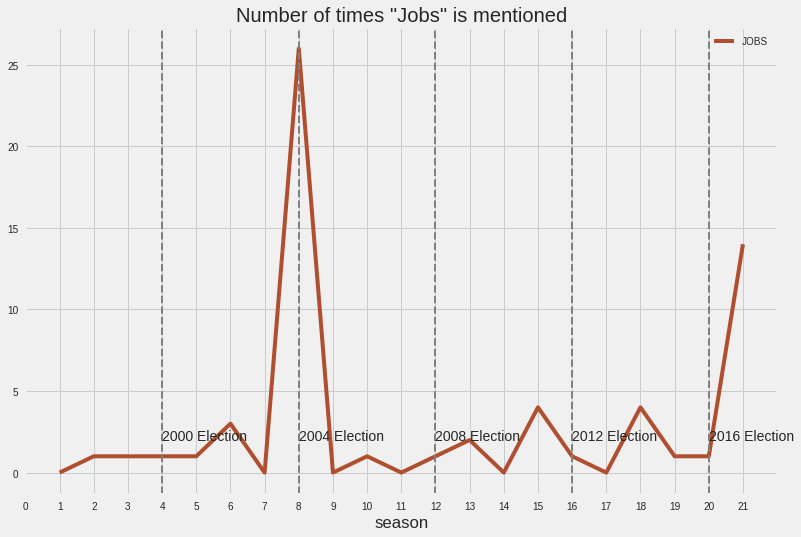

In [36]:
r = int(randint(10, 90))
g = int(randint(10, 90))
b = int(randint(10, 90))
color = [r*.01, g*.01, b*.01]

pres = word_freq.groupby(['season'])[['JOBS']].sum()
pres.plot(xticks = range(0,22), c= color)
plt.axvline(x=4, ls = '--', lw = 2, c = 'grey')
plt.axvline(x=8, ls = '--', lw = 2, c = 'grey')
plt.axvline(x=12, ls = '--', lw = 2, c = 'grey')
plt.axvline(x=16, ls = '--', lw = 2, c = 'grey')
plt.axvline(x=20, ls = '--', lw = 2, c = 'grey')
plt.annotate('2000 Election',xy=(4,2))
plt.annotate('2004 Election',xy=(8,2))
plt.annotate('2008 Election',xy=(12,2))
plt.annotate('2012 Election',xy=(16,2))
plt.annotate('2016 Election',xy=(20,2))
plt.title('Number of times "Jobs" is mentioned')

 ## Regression Analysis (Poll numbers vs. Sentiments)

Run regression with the whole sentiment analysis dataset

                            OLS Regression Results                            
Dep. Variable:               poll_num   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     2.096
Date:                Fri, 23 Mar 2018   Prob (F-statistic):              0.102
Time:                        04:31:56   Log-Likelihood:                -849.25
No. Observations:                 217   AIC:                             1706.
Df Residuals:                     213   BIC:                             1720.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           45.0605     12.720  

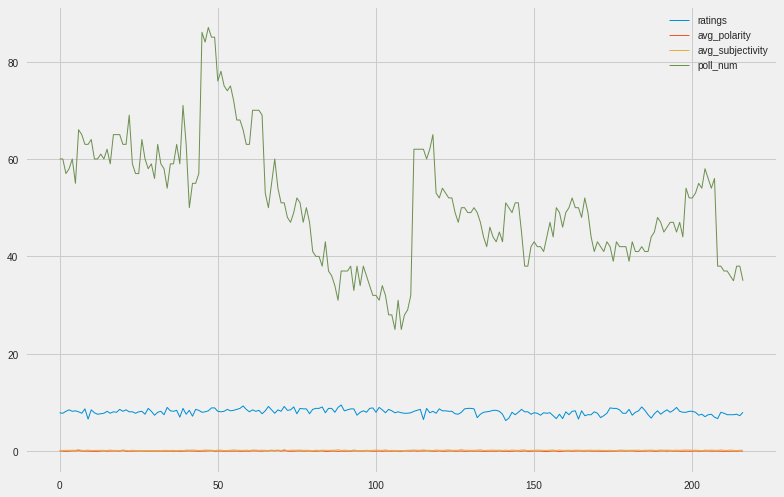

In [37]:
df_stmt_lol = df_stmt.copy()
df_stmt_lol[['poll_num']] = df_stmt_lol[['poll_num']].apply(pd.to_numeric)
df_stmt_lol = df_stmt_lol.groupby(['season', 'episode'])[['ratings', 'avg_polarity', 'avg_subjectivity', 'poll_num']].mean().reset_index()
df_stmt_lol[['ratings', 'avg_polarity', 'avg_subjectivity', 'poll_num']].plot(linewidth=1)

out, pred = patsy.dmatrices('poll_num ~ avg_polarity + avg_subjectivity + ratings', df_stmt_lol)
mod = sm.OLS(out, pred)
res = mod.fit()
print(res.summary())

The P-value for avg_polarity is 0.017, which is enough evidence to refute the null hypothesis with a threshold of 0.05, meaning that there is a significant correlation between avg_polarity and poll_num.

The coefficient of avg_polarity is 58.7135 ± 24.304, which means that the correlation between avg_polarity and poll_num is positive.

Scramble and separate data into training set and testing set

In [38]:
df_stmt_scrambled = df_stmt_lol.sample(frac=1).reset_index(drop=True)
df_stmt_scrambled.head()

,season,episode,ratings,avg_polarity,avg_subjectivity,poll_num
0,20,10,7.0,0.028028,0.189083,56
1,14,6,8.7,0.012432,0.189700,50
2,16,2,7.9,0.014686,0.224683,47
3,21,1,6.7,0.035538,0.186320,38
4,4,4,7.5,0.034860,0.182371,58


In [0]:
num_training = int(len(df_stmt_scrambled)*0.8)
num_testing = int(len(df_stmt_scrambled)*0.2)

stmt_train = df_stmt_scrambled[:num_training]
stmt_test = df_stmt_scrambled[num_training:]

Fit model with training data

In [40]:
out_train, pred_train = patsy.dmatrices('poll_num ~ ratings + avg_polarity + avg_subjectivity', stmt_train)
mod_train = sm.OLS(out_train, pred_train)
res_train = mod_train.fit()
print(res_train.summary())

                            OLS Regression Results                            
Dep. Variable:               poll_num   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.443
Date:                Fri, 23 Mar 2018   Prob (F-statistic):              0.232
Time:                        04:31:58   Log-Likelihood:                -674.88
No. Observations:                 173   AIC:                             1358.
Df Residuals:                     169   BIC:                             1370.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           44.1532     13.643  

Make predictions of the testing data with the trained model and find root mean squared error

In [41]:
out_test, pred_test = patsy.dmatrices('poll_num ~ ratings + avg_polarity + avg_subjectivity', stmt_test)
result_test = res_train.predict(pred_test)

err = np.concatenate(np.asarray(out_test))-result_test
rmse = np.sqrt(np.mean(np.square(err)))
print("Root mean squared error =", rmse)

Root mean squared error = 12.750560540162665


##Regression Analysis (Poll numbers vs. Word frequency)

In [42]:
out, pred = patsy.dmatrices('poll_num ~ ELECTION + VOTE + SHIT + MEXICO + CANADA + JOBS', word_freq)
mod = sm.OLS(out, pred)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               poll_num   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.353
Date:                Fri, 23 Mar 2018   Prob (F-statistic):              0.235
Time:                        04:31:58   Log-Likelihood:                -852.42
No. Observations:                 218   AIC:                             1719.
Df Residuals:                     211   BIC:                             1743.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     51.7437      0.978     52.933      0.0

Sh\*t is the only word that is statistically significant (at 5% level) to explain the variation in poll numbers, with a p-value of 0.011. The negative coefficient indicates that when sh\*t is mentioned frequently, it negatively affects the poll numbers.

# **Privacy/Ethics considerations :**

Using a 'script' from a popular TV show for research purposes in a machine learning algorithm is allowed within the 'fair use' description of copyright. It is our understanding that the following descriptions place the usage described within 'fair use':

Amount and substantiality of the portion used in relation to the copyrighted work as a whole.

Since we are using the script, not the video and audio, to test our hypothesis, and we are also not reproducing it for our audience, our research is protected under fair use.

Effect of the use upon the potential market for or value of the copyrighted work :

Using a script to test our hypothesis would have virtually no effect on the 'potential market or value of copyrighted work'. Section 107 of the Copyright Act provides the statutory framework for determining whether something is a fair use and identifies certain types of uses—such as criticism, comment, news reporting, teaching, scholarship, and research—as examples of activities that may qualify as fair use.



# **Conclusion, Discussion, and Future Work:**

## Conclusion
We tested the hypothesis by analyzing different features of a South Park episode. Because politics often depend on sentiments on a small set of topics, we decided to apply sentiment and word frequency analysis on South Park--specifically South Park scripts. In the real world, sentiments of political parties, and by extension the party's stances on political ideas, are reflected by poll data: Democrat/Republican party approval ratings, Presidential job approval ratings, and Presidential candidate approval ratings. We collected and cleaned the Presidential job approval poll data for each week from 1997 till present (Clinton to Trump administrations), and then used our two features to see if there are any trends.

A preliminary graphing of the sentiment data shows that all characters were fairly neutral and even leaned towards positive sentiments rather than negative sentiments. This is surprising, because characters such as Eric Cartman or Mr. Herber Garrison are known for their negative sentiments on the show, and yet seemed neutral or positive. For the sentiment analysis, we compared the average sentiment of a character for each episode versus the Presidential job approval ratings of the following week. 

A precursor examination of the word frequency data revealed that certain words tended to peak or drop in frequency during election years. Words such as 'election' and 'vote' peaked during these years while, surprisingly, the word 'sh\*t' dropped during the same years. These intial findings were as expected because, as a political cartoon, it is reasonable for it to talk about and explore voting and election sentiments as well as results. For the word frequency analysis, we compared the frequency of a list of words consisting of hotly debated topics (e.g. 'Mexico', 'jobs', and 'vote') per episode versus the Presidential job approval ratings of the next week.

We used regression analysis on both the sentiment analysis dataset and the word frequency dataset. On the sentiment analysis dataset, we found significant positive correlation between the overall sentiment of the show and the poll data. While this is only a correlation, we can still make predictions of the weekly poll data corresponding to an episode given the sentiment value of the episode. We scrambled our data and used 80% of the data for training a prediction model and 20% for testing. The resulted mean squared error is relatively small when taking into consideration the scale of poll data. On the word frequency data, we picked out certain words that we thought would correlate with public political sentiment and ran another regression analysis. We discovered the word 'sh\*t' surprisingly has a significant negative correlation with the poll numbers. One could theorize that this correlation is due to the negative connotation of this taboo word--the more someone says it, the more negative the overall sentiment is. 

## Discussion
There are potential biases in the data since dialogues of TV shows are written by screenwriters of those TV shows; the dialogues might reflect the political leaning of the writers and the tone of the shows. However, a point can be made that shows like South Park tend to poke fun at both sides of the political spectrum, therefore giving plenty of data (both positive and negative) on each candidate for us to work with. Since our topic concerns politics, there will always be biases, but political biases are in fact what we are trying to study here, as we want to examine the political impact of satire TV shows and how they bias people's feelings about certain political figure or ideology. Therefore, biases in dialogues are not big issues here. Other data we use in this research are poll numbers. Different institutions do polls and often get different numbers throughout the years. Poll numbers might not be an accurate representation of popularity. For example, in the 2016 election, Donald Trump won over Hillary Clinton despite poll numbers favoring Clinton. To mitigate this effect we take the average of different polls to best reflect actual feelings of voters.

As a result of the specific datasets we gathered for analysis, there may also be several other confounding factors. A TV show isn't only composed of lines of scripts; there are visual and audio elements. Screentime, characters' actions on-screen, and even background music can affect the audience. However, analyzing these elements would require more advanced techniques, such as image recognition, entity recognition, and audio interpreters. Moreover, certain weeks are missing in the poll data scaped from UCSB, but are complete in other closed datasets. If given access to these processed data, then our analysis and conclusions will be more complete.

## Did It Work?
After visualizing our dataset, and looking at the results of our prediction model, we concluded that our hypothesis seems to be true about the positive correlation between the displayed political sentiments in television shows, and the political climate in America. In other words, the 21st century trend of different forms of media affecting voting continues. Just like social media (Facebook) affected voting, and people's perception by creatiing echo chambers, it is possible that different forms of media (television shows in this case) have an impact on our sentiments towards a political candidate!

## Future Work
Our work can act as the starting point for further research on causation. There needs to be an experiment formed that uses double dissociation to test whether this correlation is a causation, or not. These experiements need to be controlled for which TV shows they watch as well as their political inclinations. From these experiements, we can determine if TV shows do shape America's political climate and prove a causation relationship.

Moreover, our work can be expanded to other TV shows, like The Simpsons, King of the Hill, Family Guy, Rick and Morty, etc. Although these shows many not be political in nature, they do encompass political topics since these shows do tend to reflect popular culture.

If TV shows do turn out affect politics, this will be a groundbreaking discovery, and can change the extent and dimention to which advertising and marketing can reach. Soon, it can lead to South Park as well as other TV shows having sponsors that are paying, or rather bribing, the script writers in millions just to display a positive sentiment towards their candidate and political party to improve public perception.